In [1]:
from pydicom import dcmread
from pydicom.data import get_testdata_files

filename = get_testdata_files('MR_small.dcm')[0]
ds = dcmread(filename)

print(ds)

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 190
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.5962.1.1.4.1.1.20040826185059.5457
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.3.6.1.4.1.5962.2
(0002,0013) Implementation Version Name         SH: 'DCTOOL100'
(0002,0016) Source Application Entity Title     AE: 'CLUNIE1'
-------------------------------------------------
(0008,0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'OTHER']
(0008,0012) Instance Creation Date              DA: '20040826'
(0008,0013) Instance Creation Time              TM: '185434'
(0008,0014) Instance Creator UID                UI: 1.3.6.1.4.1.5962.3
(0008,0016) SOP Class UID                       UI: MR I

In [2]:
print(ds.PatientName)
print(ds[0x10,0x10].value)
print(ds[0x100010].value)

CompressedSamples^MR1
CompressedSamples^MR1
CompressedSamples^MR1


In [5]:
# to alter the name of patient
# ds.PatientName = 'anonymous'

# del the col of patient name
# del ds[0x10,0x10]

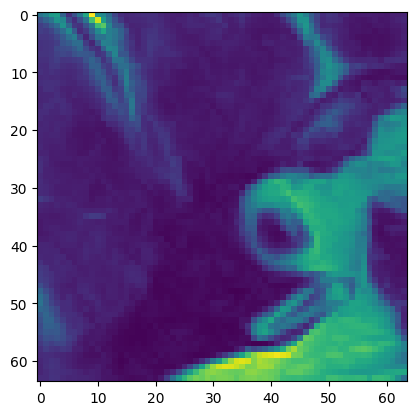

In [4]:
import matplotlib.pyplot as plt
plt.imshow(ds.pixel_array)
plt.show()

In [7]:
print(ds.Rows, ds.Columns)
# downsample the image
data_downsampling = ds.pixel_array[::4, ::4]

# put the downsampled image back to the dicom dataset
ds.PixelData = data_downsampling.tobytes()

# update the size of the image
ds.Rows, ds.Columns = data_downsampling.shape
print(ds.Rows, ds.Columns)


64 64
16 16


In [ ]:
# save as new dicom
# ds.save_as('new.dcm')

# process CT

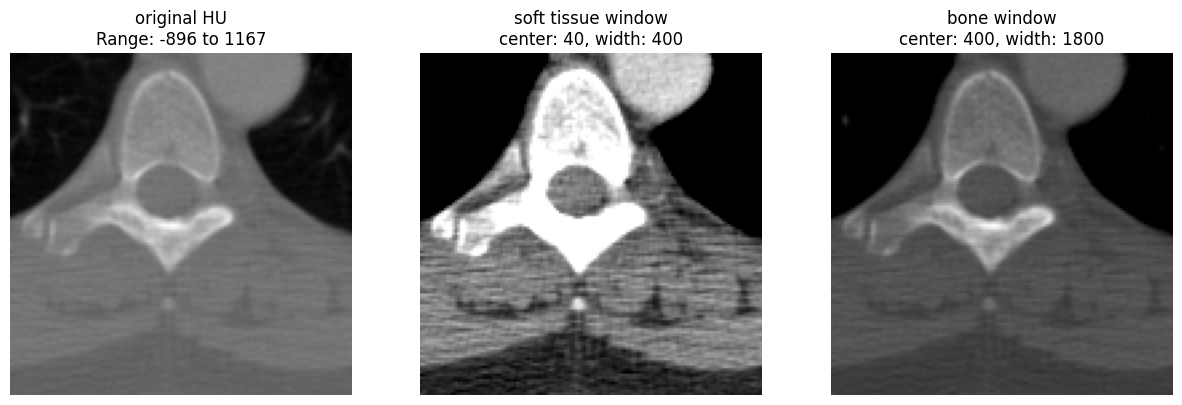

In [ ]:
import pydicom
from pydicom.data import get_testdata_files
import numpy as np
import matplotlib.pyplot as plt

def read_dicom(file_path):
    ds = pydicom.dcmread(file_path)

    image = ds.pixel_array.astype(np.float32)

    # transform to HU 
    # HU = pixel_value * slope + intercept
    slope = getattr(ds, 'RescaleSlope', 1)
    intercept = getattr(ds, 'RescaleIntercept', 0)
    hu_image = image * slope + intercept

    return hu_image

# define windowing (for visualizaiton)
def apply_window(image, center, width):
    img_min = center - width // 2
    img_max = center + width // 2
    windowed = np.clip(image, img_min, img_max)
    return windowed

filename = get_testdata_files('CT_small.dcm')[0]
hu_image = read_dicom(filename)

# 臨床常用窗位 (center/width)
# 軟組織 soft tissue: 40 / 400
# 骨骼 bone: 400 / 1800
soft_tissue = apply_window(hu_image, 40, 400)
bone_window = apply_window(hu_image, 400, 1800)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(hu_image, cmap='gray')
axes[0].set_title(f'original HU\nRange: {hu_image.min():.0f} to {hu_image.max():.0f}')

axes[1].imshow(soft_tissue, cmap='gray')
axes[1].set_title('soft tissue window\ncenter: 40, width: 400')

axes[2].imshow(bone_window, cmap='gray')
axes[2].set_title('bone window\ncenter: 400, width: 1800')

for ax in axes: ax.axis('off')
plt.show()



# process MRI

模態 modality: MR
像素格式 pixel representation: 1
像素間距 pixel spacing: [0.3125, 0.3125]
影像尺寸 size: 64 X 64


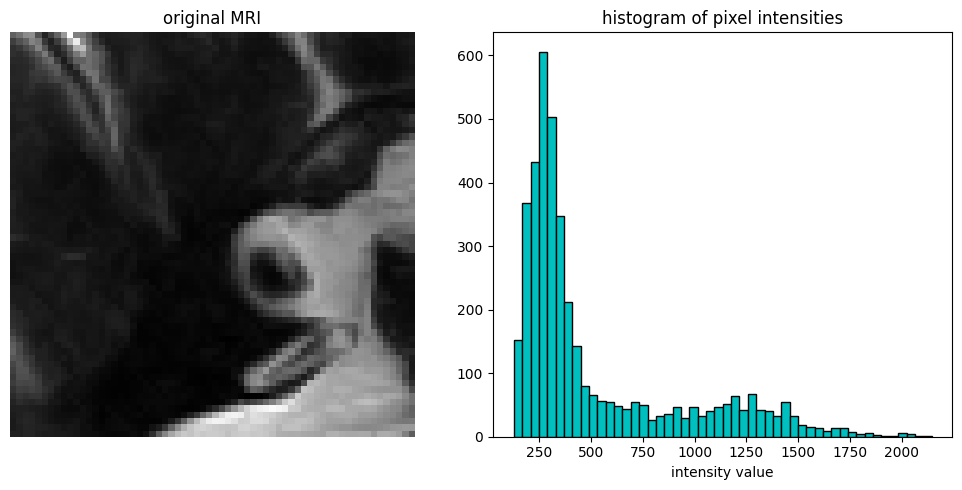

In [4]:
import pydicom
from pydicom.data import get_testdata_files
import matplotlib.pyplot as plt
import numpy as np

filename = get_testdata_files('MR_small.dcm')[0]
ds = pydicom.dcmread(filename)

print(f'模態 modality: {ds.Modality}')
print(f'像素格式 pixel representation: {ds.PixelRepresentation}')
print(f'像素間距 pixel spacing: {ds.PixelSpacing}')
print(f'影像尺寸 size: {ds.Rows} X {ds.Columns}')

# get the pixel value of the iamge
image = ds.pixel_array.astype(np.float32)

# normalize
img_min = np.min(image)
img_max = np.max(image)
norm_image = (image - img_min) / (img_max - img_min)

# visualization
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('original MRI')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('histogram of pixel intensities')
plt.hist(image.flatten(), bins=50, color='c', edgecolor='black')
plt.xlabel('intensity value')

plt.tight_layout()
plt.show()
